# Forecasting taxi orders

A taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, we need to predict the number of taxi orders for the next hour. We build a model to make this prediction.

The value of the *RMSE* metric on the test sample should be no more than 48.

We need to:

1. Load the data and resample it by hour.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
data.index.name = None

In [4]:
data = data.resample('1H').sum()

In [5]:
data['num_orders']

2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

In [6]:
data.index.is_monotonic

True

In [7]:
data.index.year.unique()

Int64Index([2018], dtype='int64')

In [8]:
data['month'] = data.index.month
data['week'] = data.index.week
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

/tmp/ipykernel_81/424865700.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week'] = data.index.week


In [9]:
data.head()

,num_orders,month,week,dayofweek,hour
2018-03-01 00:00:00,124,3,9,3,0
2018-03-01 01:00:00,85,3,9,3,1
2018-03-01 02:00:00,71,3,9,3,2
2018-03-01 03:00:00,66,3,9,3,3
2018-03-01 04:00:00,43,3,9,3,4


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
 1   month       4416 non-null   int64
 2   week        4416 non-null   int64
 3   dayofweek   4416 non-null   int64
 4   hour        4416 non-null   int64
dtypes: int64(5)
memory usage: 207.0 KB


**Description of preprocessing:**

The data was re-indexed and resampled hourly. The following characteristics were created: quarter of the year, month, week number of the year, day of the week and hour of travel.

## Analysis

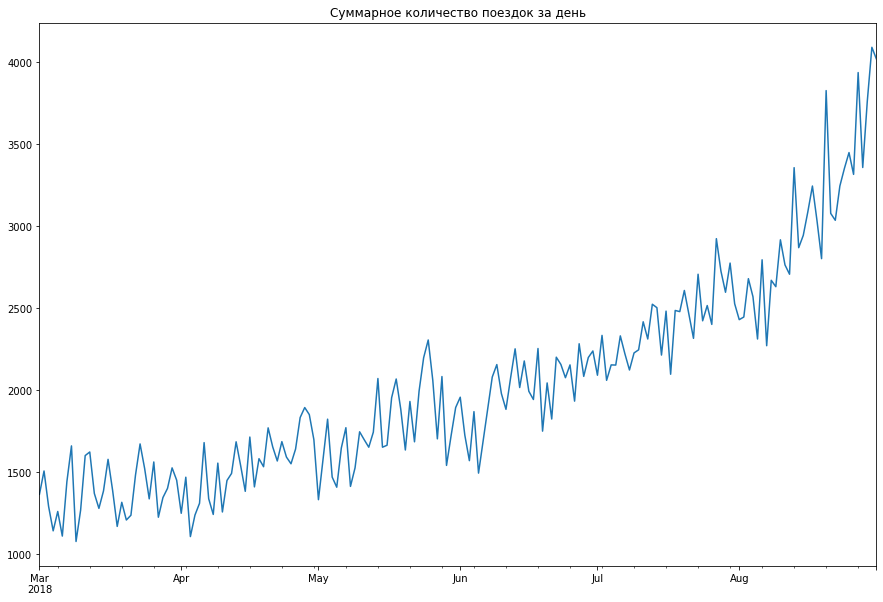

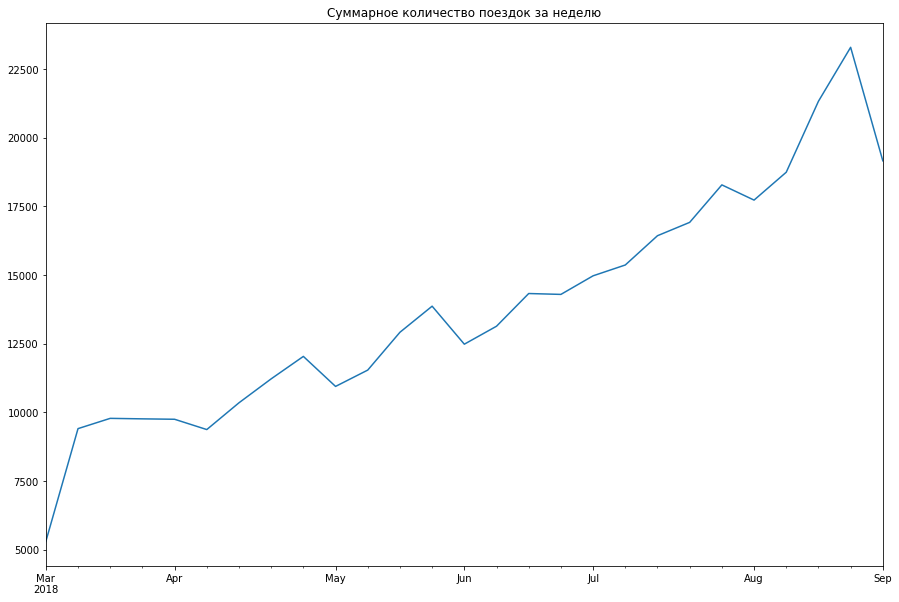

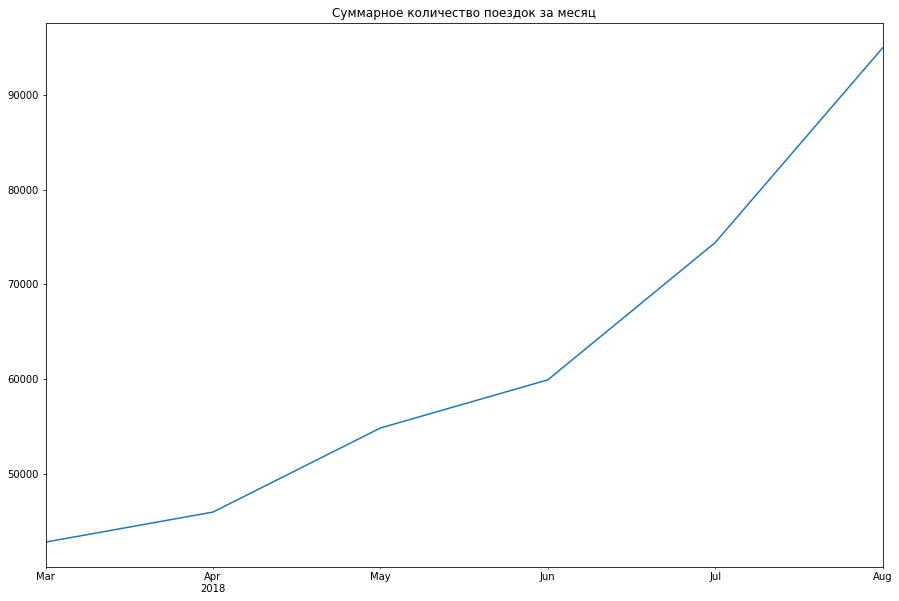

In [11]:
for sample in [['1D', 'Суммарное количество поездок за день'],
               ['1W', 'Суммарное количество поездок за неделю'],
               ['1M', 'Суммарное количество поездок за месяц']]:
    
    data['num_orders'].resample(sample[0]).sum().plot(figsize=(15, 10))
    plt.title(sample[1])
    plt.show()

Text(0.5, 1.0, 'Скользящее среднее количество заказов в день')

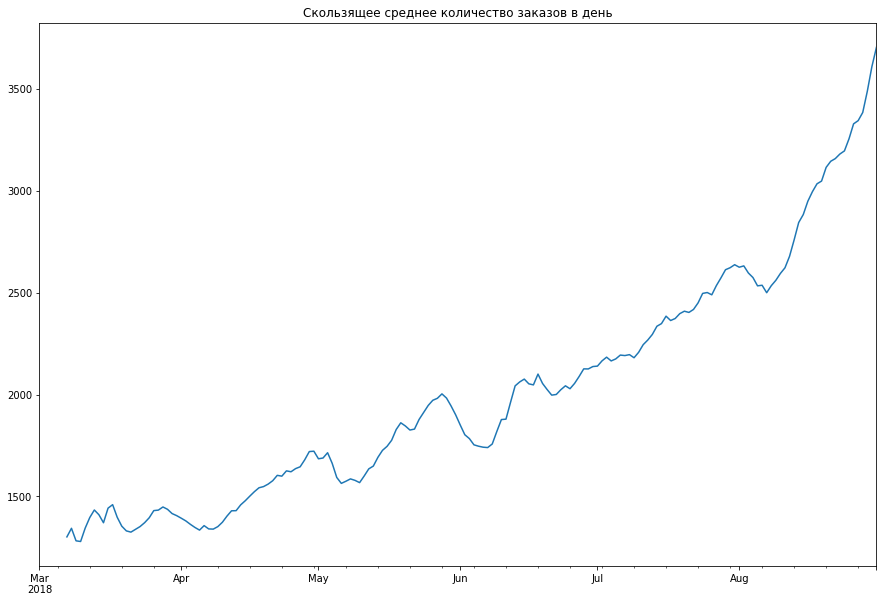

In [12]:
data['num_orders'].resample('1D').sum().rolling(7).mean().plot(figsize=(15, 10))
plt.title('Скользящее среднее количество заказов в день')

<AxesSubplot:xlabel='dayofweek', ylabel='hour'>

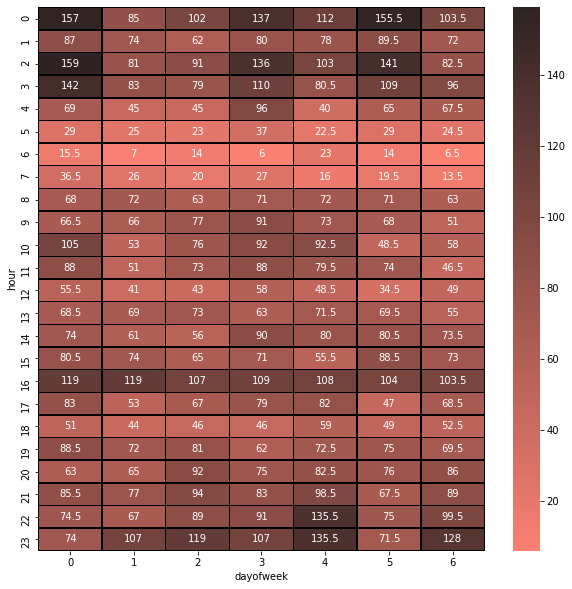

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(data
            .query('month == 5')
            .pivot_table(index='hour', 
                         columns='dayofweek', 
                         values='num_orders', 
                         aggfunc='median'),
#            .apply(lambda x: (x-x.mean())/x.std(), axis=1),
           annot=True, fmt='g',
           linewidth=0.5, linecolor='black', cmap=sns.color_palette("dark:salmon_r", as_cmap=True))

<AxesSubplot:xlabel='dayofweek', ylabel='month'>

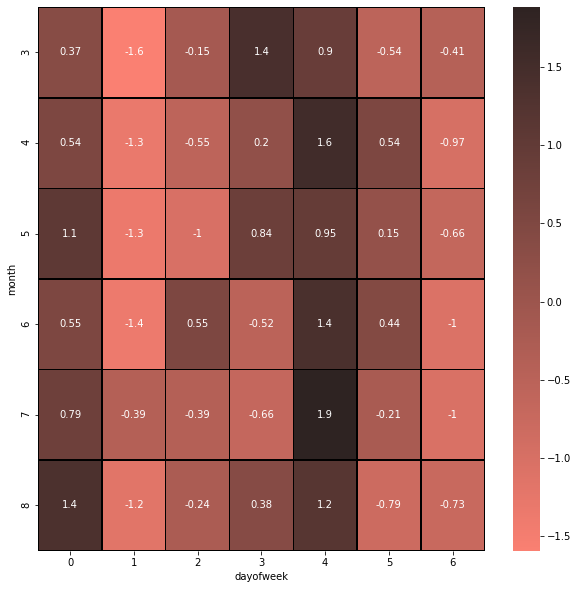

In [14]:
plt.figure(figsize=(10, 10))
sns.heatmap(data
            .pivot_table(index='month', 
                         columns='dayofweek', 
                         values='num_orders', 
                         aggfunc='median')
            .apply(lambda x: (x-x.mean())/x.std(), axis=1),
           annot=True, fmt='.2g',
           linewidth=0.5, linecolor='black', cmap=sns.color_palette("dark:salmon_r", as_cmap=True))

<AxesSubplot:title={'center':'Количество поездок по неделям'}, xlabel='dayofweek'>

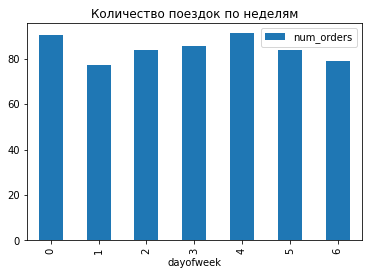

In [15]:
(data
 .pivot_table(index='dayofweek', values='num_orders', aggfunc='mean')
 .plot(kind='bar', title='Количество поездок по неделям')
)

<AxesSubplot:title={'center':'Количество поездок по часам'}, xlabel='hour'>

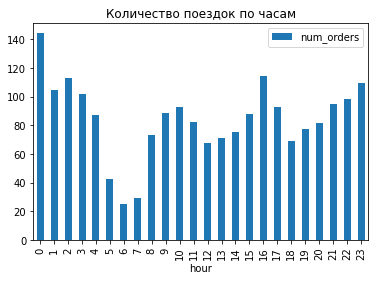

In [16]:
(data
 .pivot_table(index='hour', values='num_orders', aggfunc='mean')
 .plot(kind='bar', title='Количество поездок по часам')
)

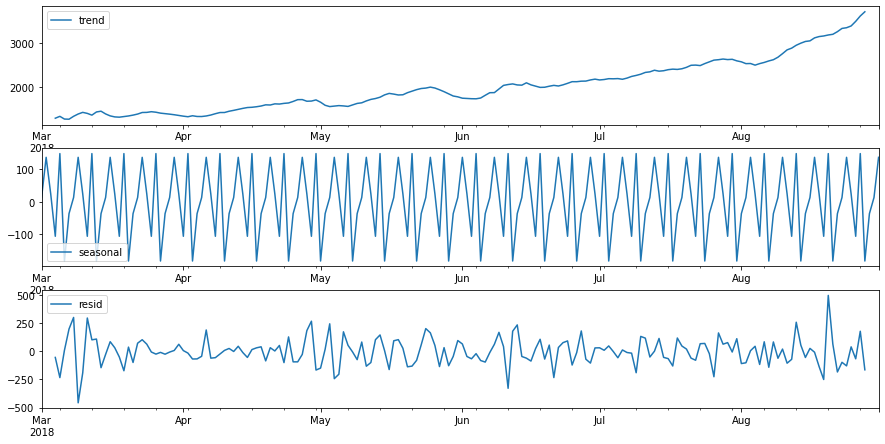

In [17]:
decomposed = seasonal_decompose(data['num_orders'].resample('1D').sum())

plt.figure(figsize=(15, 10))

plt.subplot(411)
decomposed.trend.plot()
plt.legend()

plt.subplot(412)
decomposed.seasonal.plot()
plt.legend()

plt.subplot(413)
decomposed.resid.plot()
plt.legend()

plt.show()

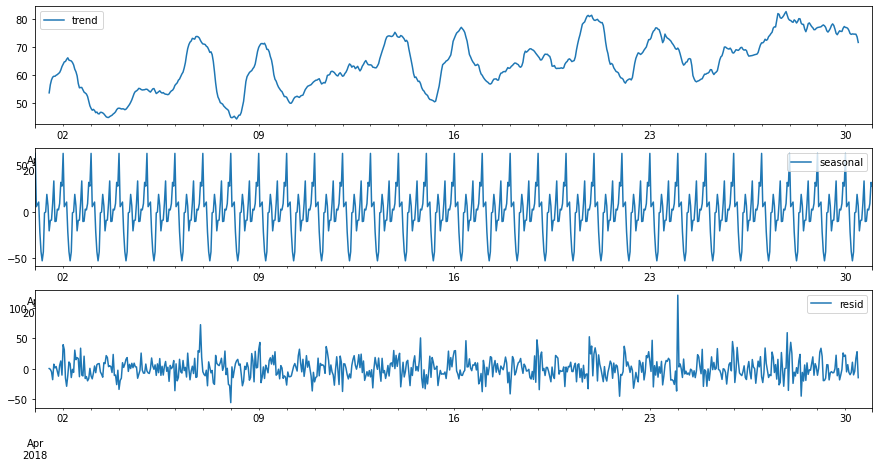

In [18]:
decomposed_hour = seasonal_decompose(data['num_orders']['2018-04':'2018-04'])

plt.figure(figsize=(15, 10))

plt.subplot(411)
decomposed_hour.trend.plot()
plt.legend()

plt.subplot(412)
decomposed_hour.seasonal.plot()
plt.legend()

plt.subplot(413)
decomposed_hour.resid.plot()
plt.legend()

plt.show()

**Description of research analysis:**

On average, there are more trips on Mondays and Fridays, as well as at 24:00 - 03:00. The least - on Tuesdays and Sundays and in the morning from 5 o'clock until 7 o'clock.

In general, in 2018 there was a strong trend towards an increase in the number of trips.

## Training

In [19]:
data.drop(columns='month', inplace=True)

In [20]:
data['lag_1'] = data['num_orders'].shift(1)
data['lag_2'] = data['num_orders'].shift(2)
data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()
data.dropna(inplace=True)

In [21]:
data.columns

Index(['num_orders', 'week', 'dayofweek', 'hour', 'lag_1', 'lag_2',
       'rolling_mean'],
      dtype='object')

In [22]:
data.head()

,num_orders,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-03-02 00:00:00,90,9,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,9,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,75,9,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,64,9,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,20,9,4,4,64.0,75.0,56.958333


In [23]:
features = data.drop(columns='num_orders')
target = data['num_orders']

tscv = TimeSeriesSplit(n_splits=3, test_size=round(0.1*len(data))) # Test sample of 10% as required

In [24]:
data.head()

,num_orders,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-03-02 00:00:00,90,9,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,9,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,75,9,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,64,9,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,20,9,4,4,64.0,75.0,56.958333


In [25]:
data.tail()

,num_orders,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-08-31 19:00:00,136,35,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,35,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,35,4,21,154.0,136.0,168.041667
2018-08-31 22:00:00,223,35,4,22,159.0,154.0,166.416667
2018-08-31 23:00:00,205,35,4,23,223.0,159.0,169.125000


In [26]:
all_splits = list(tscv.split(features, target))

train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]

display(features.iloc[train_0])
display(features.iloc[test_0])

display(features.iloc[train_1])
display(features.iloc[test_1])

display(features.iloc[train_2])
display(features.iloc[test_2])

,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-03-02 00:00:00,9,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,9,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,9,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,9,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,9,4,4,64.0,75.0,56.958333
...,...,...,...,...,...,...
2018-07-07 22:00:00,27,5,22,72.0,76.0,93.541667
2018-07-07 23:00:00,27,5,23,91.0,72.0,92.041667
2018-07-08 00:00:00,27,6,0,119.0,91.0,92.541667
2018-07-08 01:00:00,27,6,1,99.0,119.0,88.750000


,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-07-08 03:00:00,27,6,3,109.0,94.0,85.500000
2018-07-08 04:00:00,27,6,4,192.0,109.0,88.750000
2018-07-08 05:00:00,27,6,5,82.0,192.0,86.041667
2018-07-08 06:00:00,27,6,6,73.0,82.0,87.083333
2018-07-08 07:00:00,27,6,7,44.0,73.0,87.916667
...,...,...,...,...,...,...
2018-07-26 05:00:00,30,3,5,131.0,141.0,106.666667
2018-07-26 06:00:00,30,3,6,83.0,131.0,107.250000
2018-07-26 07:00:00,30,3,7,21.0,83.0,105.416667
2018-07-26 08:00:00,30,3,8,39.0,21.0,104.541667


,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-03-02 00:00:00,9,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,9,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,9,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,9,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,9,4,4,64.0,75.0,56.958333
...,...,...,...,...,...,...
2018-07-26 05:00:00,30,3,5,131.0,141.0,106.666667
2018-07-26 06:00:00,30,3,6,83.0,131.0,107.250000
2018-07-26 07:00:00,30,3,7,21.0,83.0,105.416667
2018-07-26 08:00:00,30,3,8,39.0,21.0,104.541667


,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-07-26 10:00:00,30,3,10,138.0,80.0,105.791667
2018-07-26 11:00:00,30,3,11,142.0,138.0,107.750000
2018-07-26 12:00:00,30,3,12,86.0,142.0,107.458333
2018-07-26 13:00:00,30,3,13,102.0,86.0,108.250000
2018-07-26 14:00:00,30,3,14,70.0,102.0,107.041667
...,...,...,...,...,...,...
2018-08-13 12:00:00,33,0,12,144.0,156.0,139.875000
2018-08-13 13:00:00,33,0,13,92.0,144.0,138.583333
2018-08-13 14:00:00,33,0,14,119.0,92.0,138.541667
2018-08-13 15:00:00,33,0,15,102.0,119.0,138.458333


,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-03-02 00:00:00,9,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,9,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,9,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,9,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,9,4,4,64.0,75.0,56.958333
...,...,...,...,...,...,...
2018-08-13 12:00:00,33,0,12,144.0,156.0,139.875000
2018-08-13 13:00:00,33,0,13,92.0,144.0,138.583333
2018-08-13 14:00:00,33,0,14,119.0,92.0,138.541667
2018-08-13 15:00:00,33,0,15,102.0,119.0,138.458333


,week,dayofweek,hour,lag_1,lag_2,rolling_mean
2018-08-13 17:00:00,33,0,17,144.0,175.0,139.166667
2018-08-13 18:00:00,33,0,18,152.0,144.0,140.708333
2018-08-13 19:00:00,33,0,19,104.0,152.0,141.791667
2018-08-13 20:00:00,33,0,20,91.0,104.0,142.166667
2018-08-13 21:00:00,33,0,21,82.0,91.0,141.500000
...,...,...,...,...,...,...
2018-08-31 19:00:00,35,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,35,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,35,4,21,154.0,136.0,168.041667
2018-08-31 22:00:00,35,4,22,159.0,154.0,166.416667


In [27]:
gbdt = lgb.LGBMRegressor(
    task = 'train',
    objective = "regression",
    boosting = "gbdt",
    num_leaves = 32,
    learning_rate = 0.15,
    max_depth = 5,
    min_gain_to_split = 0.5,
    verbose= -1)
score_gbdt = cross_val_score(gbdt, features, target, cv=tscv, scoring='neg_root_mean_squared_error').mean() 
print(score_gbdt)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
-33.53114930308015


In [28]:
gbdt

LGBMRegressor(boosting='gbdt', learning_rate=0.15, max_depth=5,
              min_gain_to_split=0.5, num_leaves=32, objective='regression',
              task='train', verbose=-1)

In [29]:
dart = lgb.LGBMRegressor(
    task = 'train',
    objective = "regression",
    boosting = "dart",
    num_leaves = 40,
    learning_rate = 0.5,
    max_depth = 6,
    min_gain_to_split = 0.01,
    verbose= -1)
score_dart = cross_val_score(dart, features, target, cv=tscv, scoring='neg_root_mean_squared_error').mean() 
print(score_dart)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
-34.8056944914548


In [30]:
dart

LGBMRegressor(boosting='dart', learning_rate=0.5, max_depth=6,
              min_gain_to_split=0.01, num_leaves=40, objective='regression',
              task='train', verbose=-1)

In [31]:
goss = lgb.LGBMRegressor(
    task = 'train',
    objective = "regression",
    boosting = "goss",
    num_leaves = 40,
    learning_rate = 0.05,
    top_rate = 0.2,               
    other_rate = 0.2,
    verbose= -1)
score_goss = cross_val_score(goss, features, target, cv=tscv, scoring='neg_root_mean_squared_error').mean() 
print(score_goss)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
-34.28916093402963


In [32]:
goss

LGBMRegressor(boosting='goss', learning_rate=0.05, num_leaves=40,
              objective='regression', other_rate=0.2, task='train',
              top_rate=0.2, verbose=-1)

In [33]:
forest = None
score = -5000

for est in [10, 20]:
    for depth in [5, 10]:
        for samples in [5, 15]:
            
            forest_0 = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth, min_samples_leaf=samples)
            score_0 = cross_val_score(forest_0, features, target, cv=tscv, scoring='neg_root_mean_squared_error').mean()
            
            if score_0 > score:
                score = score_0
                forest = forest_0

print(score)

-35.02370212953883


In [34]:
forest

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=20,
                      random_state=12345)

In [35]:
gbdt.fit(features, target)
dart.fit(features, target)
goss.fit(features, target)
forest.fit(features, target)

predictions_gbdt = gbdt.predict(features)
predictions_dart = dart.predict(features)
predictions_goss = goss.predict(features)
predictions_forest = forest.predict(features)

rmse_gbdt = mean_squared_error(target, predictions_gbdt)**0.5
mae_gbdt = mean_absolute_error(target, predictions_gbdt)

rmse_dart = mean_squared_error(target, predictions_dart)**0.5
mae_dart = mean_absolute_error(target, predictions_dart)

rmse_goss = mean_squared_error(target, predictions_goss)**0.5
mae_goss = mean_absolute_error(target, predictions_goss)

rmse_forest = mean_squared_error(target, predictions_forest)**0.5
mae_forest = mean_absolute_error(target, predictions_forest)

print('RMSE модели LightGBM с бустингом gbdt:', rmse_gbdt)
print('MAE модели LightGBM с бустингом gbdt:', mae_gbdt)
print()

print('RMSE модели LightGBM с бустингом dart:', rmse_dart)
print('MAE модели LightGBM с бустингом dart:', mae_dart)
print()

print('RMSE модели LightGBM с бустингом goss:', rmse_goss)
print('MAE модели LightGBM с бустингом goss:', mae_goss)
print()

print('RMSE модели случайного леса:', rmse_forest)
print('MAE модели случайного леса:', mae_forest)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
RMSE модели LightGBM с бустингом gbdt: 18.33533088493222
MAE модели LightGBM с бустингом gbdt: 13.895824648727881

RMSE модели LightGBM с бустингом dart: 15.850727625247616
MAE модели LightGBM с бустингом dart: 11.996873870977373

RMSE модели LightGBM с бустингом goss: 19.73285859855423
MAE модели LightGBM с бустингом goss: 14.60656653307604

RMSE модели случайного леса: 19.73187542561329
MAE модели случайного леса: 14.39042581638237


**Model training summary:**

Since the taxi demand forecast is only needed for an hour, the column with the month is not informative, so it was removed. New features have also been added. lag_1 and lag_2 show the models how much demand in the previous 2 hours affects current demand. A daily moving average of demand was also added. Missing values were removed. The sample is divided into 3 consecutive training and test samples in a ratio of 90:10 for further cross-validation. We used LightGBM models with different types of boosting and other hyperparameters (num_leaves, learning_rate, top_rate, other_rate), as well as a random forest model with hyperparameter tuning. The gbdt model performed best on cross-validation.

## Testing

In [36]:
target.iloc[-round(0.1*len(data)):]

2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
2018-08-13 20:00:00     82
2018-08-13 21:00:00    160
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 439, dtype: int64

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5


Text(0.5, 1.0, 'Количество заказов за последние 18 суток')

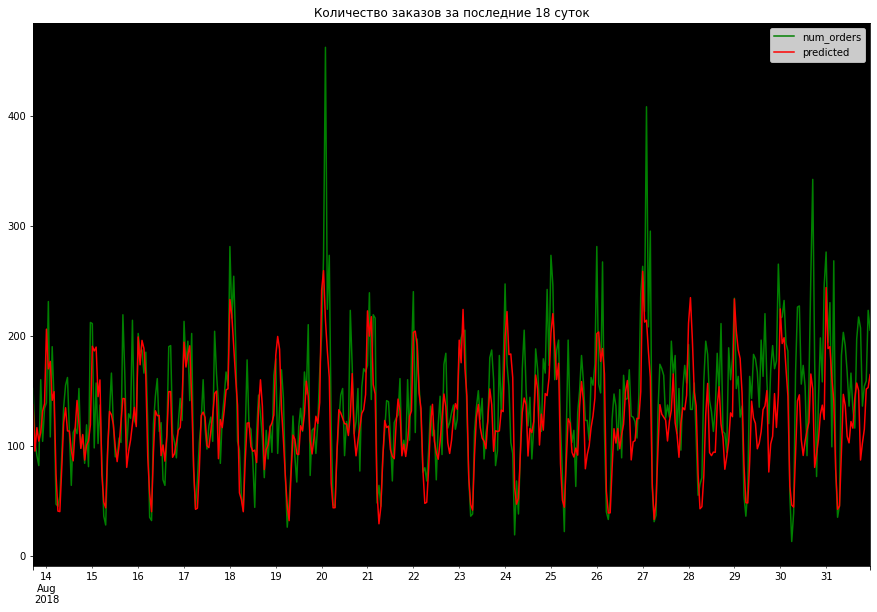

In [37]:
gbdt.fit(features.iloc[:-round(0.1*len(data))], target.iloc[:-round(0.1*len(data))])

plt.figure(figsize=(15, 10))
plt.axes().set_facecolor("black")

target.iloc[-round(0.1*len(data)):].plot(legend=True, color='g')
pd.DataFrame(gbdt
             .predict(features.iloc[-round(0.1*len(data)):]),
             index=target.iloc[-round(0.1*len(data)):].index, 
             columns=['predicted']).plot(color='r', ax=plt.gca())
plt.title('Количество заказов за последние 18 суток')

Based on the results of cross-validation, the gbdt model was selected. Its average RMSE was 33.5 < 48